线性判别分析(Linea Discriminant Analysis, LDA)是一种特征抽取技术，它可以提高数据分析过程的计算效率，同时对于不适用于正则化的模型，它可以降低因维度灾难带来的过拟合问题。LDA的目标是发现可以最优化分类的特征子空间，是一种有监督的算法。

**LDA可以结为以下几个关键的步骤：**  
1)对d维数据集进行标准化的处理(d为特征的数量)。  
2)对于每一个类别，计算d维的均值向量。  
3)构造类间的散布矩阵$S_{B}$以及类内的散布矩阵$S_{W}$。  
4)计算矩阵$S_{W}^{-1} S_{B}$的特征值以及对应的特征向量。  
5)选取前k个特征值所对应的特征向量，构造一个$dxk$维的转换矩阵W，其中特征向量以列的形式排列。

LDA的思想可以用一句话概括，就是“<font color=red>***投影后类内方差最小，类间方差最大***</font>”。也就是我们要将数据在低维度上进行投影，投影后希望每一种类别数据的投影点尽可能的接近，而不同类别的数据的类别中心之间的距离尽可能的大。

###### 1.导入数据并且做标准化处理

In [1]:
import pandas as pd
df_wine = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = \
                        train_test_split(X, y, test_size=0.3, random_state=0)

sc = StandardScaler()

X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

###### 2.计算均值向量

In [2]:
import numpy as np

np.set_printoptions(precision=4) # 设置浮点数的打印格式
mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train==label], axis=0))
    print('Mean Vector[%s]:%s\n' % (label, mean_vecs[label-1]))

Mean Vector[1]:[ 0.9259 -0.3091  0.2592 -0.7989  0.3039  0.9608  1.0515 -0.6306  0.5354
  0.2209  0.4855  0.798   1.2017]

Mean Vector[2]:[-0.8727 -0.3854 -0.4437  0.2481 -0.2409 -0.1059  0.0187 -0.0164  0.1095
 -0.8796  0.4392  0.2776 -0.7016]

Mean Vector[3]:[ 0.1637  0.8929  0.3249  0.5658 -0.01   -0.9499 -1.228   0.7436 -0.7652
  0.979  -1.1698 -1.3007 -0.3912]



###### 3.计算类内散布矩阵

法一：直接按定义求解，对每一个类别样本的散布矩阵做归一化后累加得到最终训练数据的散布矩阵。

In [3]:
d = 13 # number of feutures
S_W = np.zeros((d, d))

n_samples= np.bincount(y_train)[1:] # 此函数统计数组中出现的整数的个数，此处用于统计样本中各个类别的数量

for label, mv in zip(range(1, 4), mean_vecs):
    i=0
    class_scatter = np.zeros((d, d))
    for row in X_train_std[y_train == label]:
        i += 1
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)
        class_scatter += (row-mv).dot((row-mv).T) 
    class_scatter /=  n_samples[label-1] # 归一化处理，除以每个类别的样本数量
    S_W += class_scatter

print('Within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))

Within-class scatter matrix: 13x13


In [4]:
print('Class label distribution: %s' % np.bincount(y_train)[1:])

Class label distribution: [40 49 35]


法2：协方差矩阵是归一化以后的散布矩阵，两者之间只相差一个系数，故可以通过协方差来计算散布矩阵。

In [5]:
d = 13 # number of feutures
S_W = np.zeros((d, d))

for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train==label].T)
    S_W += class_scatter

print('Within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))

Within-class scatter matrix: 13x13


##### 4.计算类间散布矩阵

In [6]:
mean_overall = np.mean(X_train_std, axis=0)

d = 13
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X[y==i+1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)
    mean_overall = mean_overall.reshape(d, 1)
    S_B += n * (mean_vec - mean_overall).dot((mean_vec -mean_overall).T)
print('Between-class scatter matrix: %sx%s' % (S_B.shape[0], S_B.shape[1]))


Between-class scatter matrix: 13x13


##### 5.计算$S_{W}^{-1} S_{B}$的广义特征值，并且将特征对降序排列

In [9]:
eigen_vals, eigen_vecs = \
        np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs, key=lambda k:k[0], reverse=True) # 字典排序

print('Eigenvalues in decreasing order:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in decreasing order:

643.0153843460515
225.08698185416247
9.858090424938485e-14
8.360518905063732e-14
2.878588341817008e-14
2.878588341817008e-14
2.2954665358098825e-14
2.2954665358098825e-14
1.9539925233402755e-14
1.2379202982740725e-14
1.2379202982740725e-14
2.4182588985185695e-15
2.4182588985185695e-15


###### 6.绘制出特征值对线性判别信息的保持程度

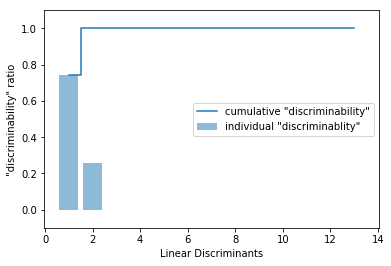

In [12]:
import matplotlib.pyplot as plt

tot = sum(eigen_vals.real) # 求所有特征值的和
discr =[(i / tot) for i in sorted(eigen_vals.real, reverse=True)] # 求每个特征值占总和的比例
cum_discr = np.cumsum(discr)
plt.bar(range(1, 14), discr, alpha=0.5, align='center', label='individual "discriminablity"')
plt.step(range(1, 14), cum_discr, where='mid', label='cumulative "discriminability"')

plt.ylabel('"discriminability" ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.show()

###### 7.叠加两个判别能力最强的特征向量构建映射矩阵

In [16]:
W = np.hstack((eigen_pairs[0][1][:, np.newaxis].real, eigen_pairs[1][1][:, np.newaxis].real))
print('Matrix W:\n', W)

Matrix W:
 [[-0.0707  0.3778]
 [ 0.0359  0.2223]
 [-0.0263  0.3813]
 [ 0.1875 -0.2955]
 [-0.0033 -0.0143]
 [ 0.2328 -0.0151]
 [-0.7719 -0.2149]
 [-0.0803 -0.0726]
 [ 0.0896 -0.1767]
 [ 0.1815  0.2909]
 [-0.0631 -0.2376]
 [-0.3794 -0.0867]
 [-0.3355  0.586 ]]


###### 8.将样本映射到新的特征空间

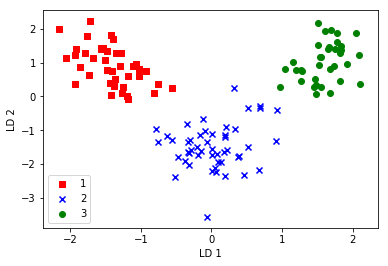

In [22]:
X_train_lda = X_train_std.dot(W)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train==l, 0], X_train_lda[y_train==l, 1], c=c, label=l, marker=m)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.show()

### 使用scikit-learn进行LDA分析

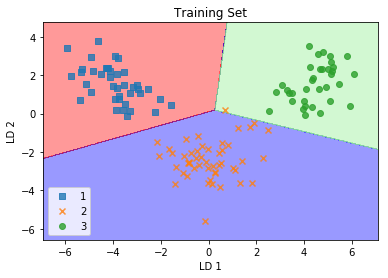

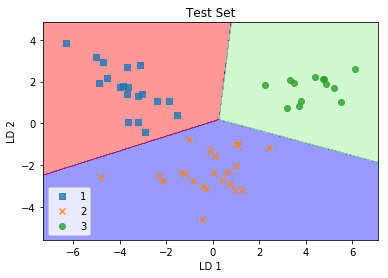

In [82]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import numpy as np
import pandas as pd

# 绘制决策区域
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    
    # setup marker generator and color map
    markers = ['s','x', 'o','^','v']
    colors = ['red', 'blue','lightgreen', 'gray','cyan']
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    """
    plot the decision surface
    将最大值，最小值向量生成二维数组xx1,xx2
    np.arange(x1_min, x1_max, resolution) 最小值最大值之间生成序列，步长为resolution
    ---
    """
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    new_x1 = np.arange(x1_min, x1_max, resolution)
    new_x2 = np.arange(x2_min, x2_max, resolution)
    xx1, xx2 = np.meshgrid(new_x1, new_x2)

    # xx1, xx2 = np.meshgrid(np.array(x1_min, x1_max, resolution), np.array(x2_min, x2_max, resolution))
    # 预测值
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap) # 绘制等高线(轮廓)，使用不同的颜色对不同区域进行填充，不专门绘制等高线，但不同颜色的分界即可代表等高线
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # plot all samples
    for idx ,c1 in enumerate(np.unique(y)):
        plt.scatter(x=X[y == c1, 0], y=X[y == c1, 1], alpha=0.8, cmap=cmap, marker=markers[idx], label=c1)

# 导葡萄酒数据集并且做标准化处理
df_wine = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
X, y =df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)


# 实现LDA类
lda = LDA(n_components=2)
lr = LogisticRegression(solver='liblinear', multi_class='auto')
lr = lr.fit(X_train_lda, y_train)

X_train_lda = lda.fit_transform(X_train_std, y_train)
plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.title('Training Set')
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.show()

X_test_lda = lda.transform(X_test_std)
plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.title('Test Set')
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.show()

总结：原始葡萄酒数据集经过LDA分析后再用来训练logistic回归模型，在测试集上取得了很优秀的分类性能。